<h1> Seattle House Price Prediction Algorithm </h1>
<p>  </p>
<img src="files/seattle.jpeg">

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import re
import folium
import time 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from folium.plugins import HeatMap

url_US_zipcodes = "https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data"
url_zip_to_city = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQpx_wI_mOREzi3PxoG8aiqd4Kp3D2txHiVyn7bGrivO5ia9sIsTa9ydaeEEcMCUuMHQiznT7rRc3XI/pub?gid=986305031&single=true&output=csv'
url_housing_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTWAIquMjpqsOk34WbFsAgvIveBF9YXHVauCV0DLAS-_RDUkMHh5IOG4ir03ECe1N_fm7s1-0wiQkE5/pub?gid=868760569&single=true&output=csv'

df = pd.read_csv(url_housing_data)
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [0]:
# Normalizing dataset
def norm(arr):
  minimum = min(arr)
  maximum = max(arr)

  return [(i - minimum) / (maximum - minimum) for i in arr]

# Getting rid of outliers by removing the top 2.5% and bottom 2.5% of data
normalized_df = df[df['price'].between(df['price'].quantile(0.025), 
                                       df['price'].quantile(0.975))]

# The number of data samples
COUNT = len(normalized_df)

# Cleaning zip_to_city csv data
zip_df = pd.read_csv(url_zip_to_city)
zip_df = zip_df.drop(['lat', 'lng', 'state_name', 'zcta', 'parent_zcta', 
                      'population', 'density', 'county_fips', 'county_name', 
                      'all_county_weights', 'imprecise', 'military', 
                      'timezone'], axis=1)
zip_df["zipcode"] = zip_df['zip'].astype(int)

# Merging the zipcode data with df
normalized_df = pd.merge(zip_df, normalized_df, how="inner", on="zipcode")

normalized_df = normalized_df.reset_index()


# For normalization, substituting rows with an empty 'yr_renovated' value
#   for a 'yr_built' value. 
normalized_df['yr_renovated'] = [normalized_df['yr_built'][i] \
                                 if normalized_df['yr_renovated'][i] == 0 \
                                 else normalized_df['yr_renovated'][i] \
                                 for i in range(COUNT)]

# Keeping the non-normalized year as reference
normalized_df['non_normalized_yr'] = normalized_df['yr_renovated']

# Fields that will be normalized
normalized_fields = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 
                     'sqft_lot', 'floors', 'view', 'condition', 'grade', 
                     'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 
                     'sqft_living15', 'sqft_lot15']

# Normalization
for i in normalized_fields:
  normalized_df[i] = norm(normalized_df[i])

# Removing the unused fields
normalized_df = normalized_df.drop(['index', 'id', 'date', 'waterfront'], 
                                   axis=1)


# Rearranging the columns
normalized_df = normalized_df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 
                               'sqft_above', 'sqft_basement', 'sqft_lot', 
                               'sqft_living15', 'sqft_lot15', 'floors', 'view', 
                               'condition', 'grade', 'yr_built', 'yr_renovated', 
                               'non_normalized_yr', 'city', 'zipcode', 'lat', 
                               'long']]

normalized_df

,price,bedrooms,bathrooms,sqft_living,sqft_above,sqft_basement,sqft_lot,sqft_living15,sqft_lot15,floors,view,condition,grade,yr_built,yr_renovated,non_normalized_yr,city,zipcode,lat,long
0,0.042146,0.121212,0.133333,0.119550,0.074820,0.115789,0.004576,0.165275,0.008212,0.0,0.00,0.25,0.444444,0.600000,0.600000,1969,Auburn,98001,47.3341,-122.282
1,0.078161,0.121212,0.333333,0.263010,0.269065,0.000000,0.002501,0.337971,0.004487,0.4,0.00,0.50,0.444444,0.913043,0.913043,2005,Auburn,98001,47.3378,-122.257
2,0.226054,0.121212,0.333333,0.402250,0.309353,0.249123,0.009481,0.415693,0.009036,0.4,0.75,0.50,0.666667,0.878261,0.878261,2001,Auburn,98001,47.3183,-122.253
3,0.214559,0.090909,0.333333,0.329677,0.337266,0.000000,0.010550,0.406418,0.020372,0.4,0.00,0.50,0.666667,0.913043,0.913043,2005,Auburn,98001,47.3185,-122.275
4,0.134100,0.121212,0.333333,0.251758,0.257554,0.000000,0.005457,0.348915,0.010667,0.4,0.00,0.50,0.666667,0.800000,0.800000,1992,Auburn,98001,47.3341,-122.255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20538,0.295019,0.090909,0.433333,0.165963,0.122302,0.115789,0.000460,0.213504,0.001066,0.4,0.00,0.50,0.666667,0.982609,0.982609,2013,Seattle,98199,47.6493,-122.384
20539,0.708812,0.121212,0.466667,0.462729,0.355396,0.287719,0.002568,0.521425,0.004582,0.4,0.00,0.50,0.666667,0.991304,0.991304,2014,Seattle,98199,47.6482,-122.409
20540,0.632184,0.121212,0.433333,0.455696,0.326619,0.340351,0.002108,0.293267,0.003847,0.4,0.00,0.50,0.666667,0.930435,0.930435,2007,Seattle,98199,47.6580,-122.396
20541,0.205364,0.090909,0.333333,0.160338,0.138129,0.063158,0.000665,0.176405,0.000857,0.6,0.00,0.50,0.555556,0.965217,0.965217,2011,Seattle,98199,47.6515,-122.384


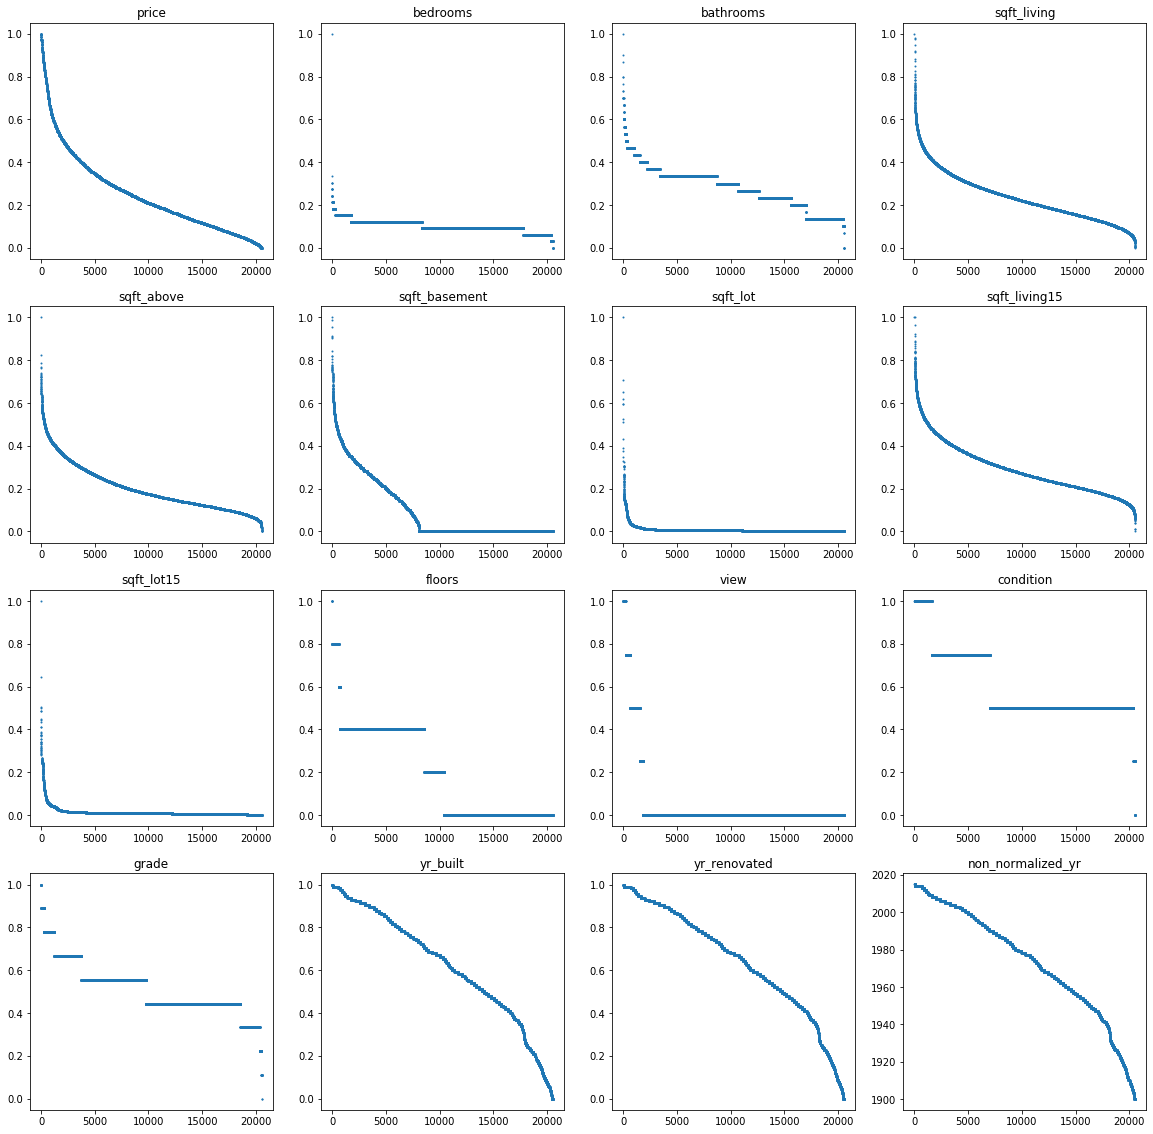

In [0]:
# Distribution of each catogory sorted from highest to lowest (post-normalized)

ROW = 4
COL = 4
counter = 0
cap = COL
fig, axes = plt.subplots(ROW, COL, figsize=(20, 20))

def convert_1d_to_2d(ind, cap):
  return (ind // cap, ind % cap)

for field in normalized_df.columns[:-4]:
  r, c = convert_1d_to_2d(counter, cap)
  counter += 1

  temp = normalized_df.sort_values(by=field, ascending=False)
  axes[r, c].set_title(field)
  axes[r, c].scatter(np.arange(COUNT), temp[field], s=1)

**Has Housing Costs Increased Over Time?**

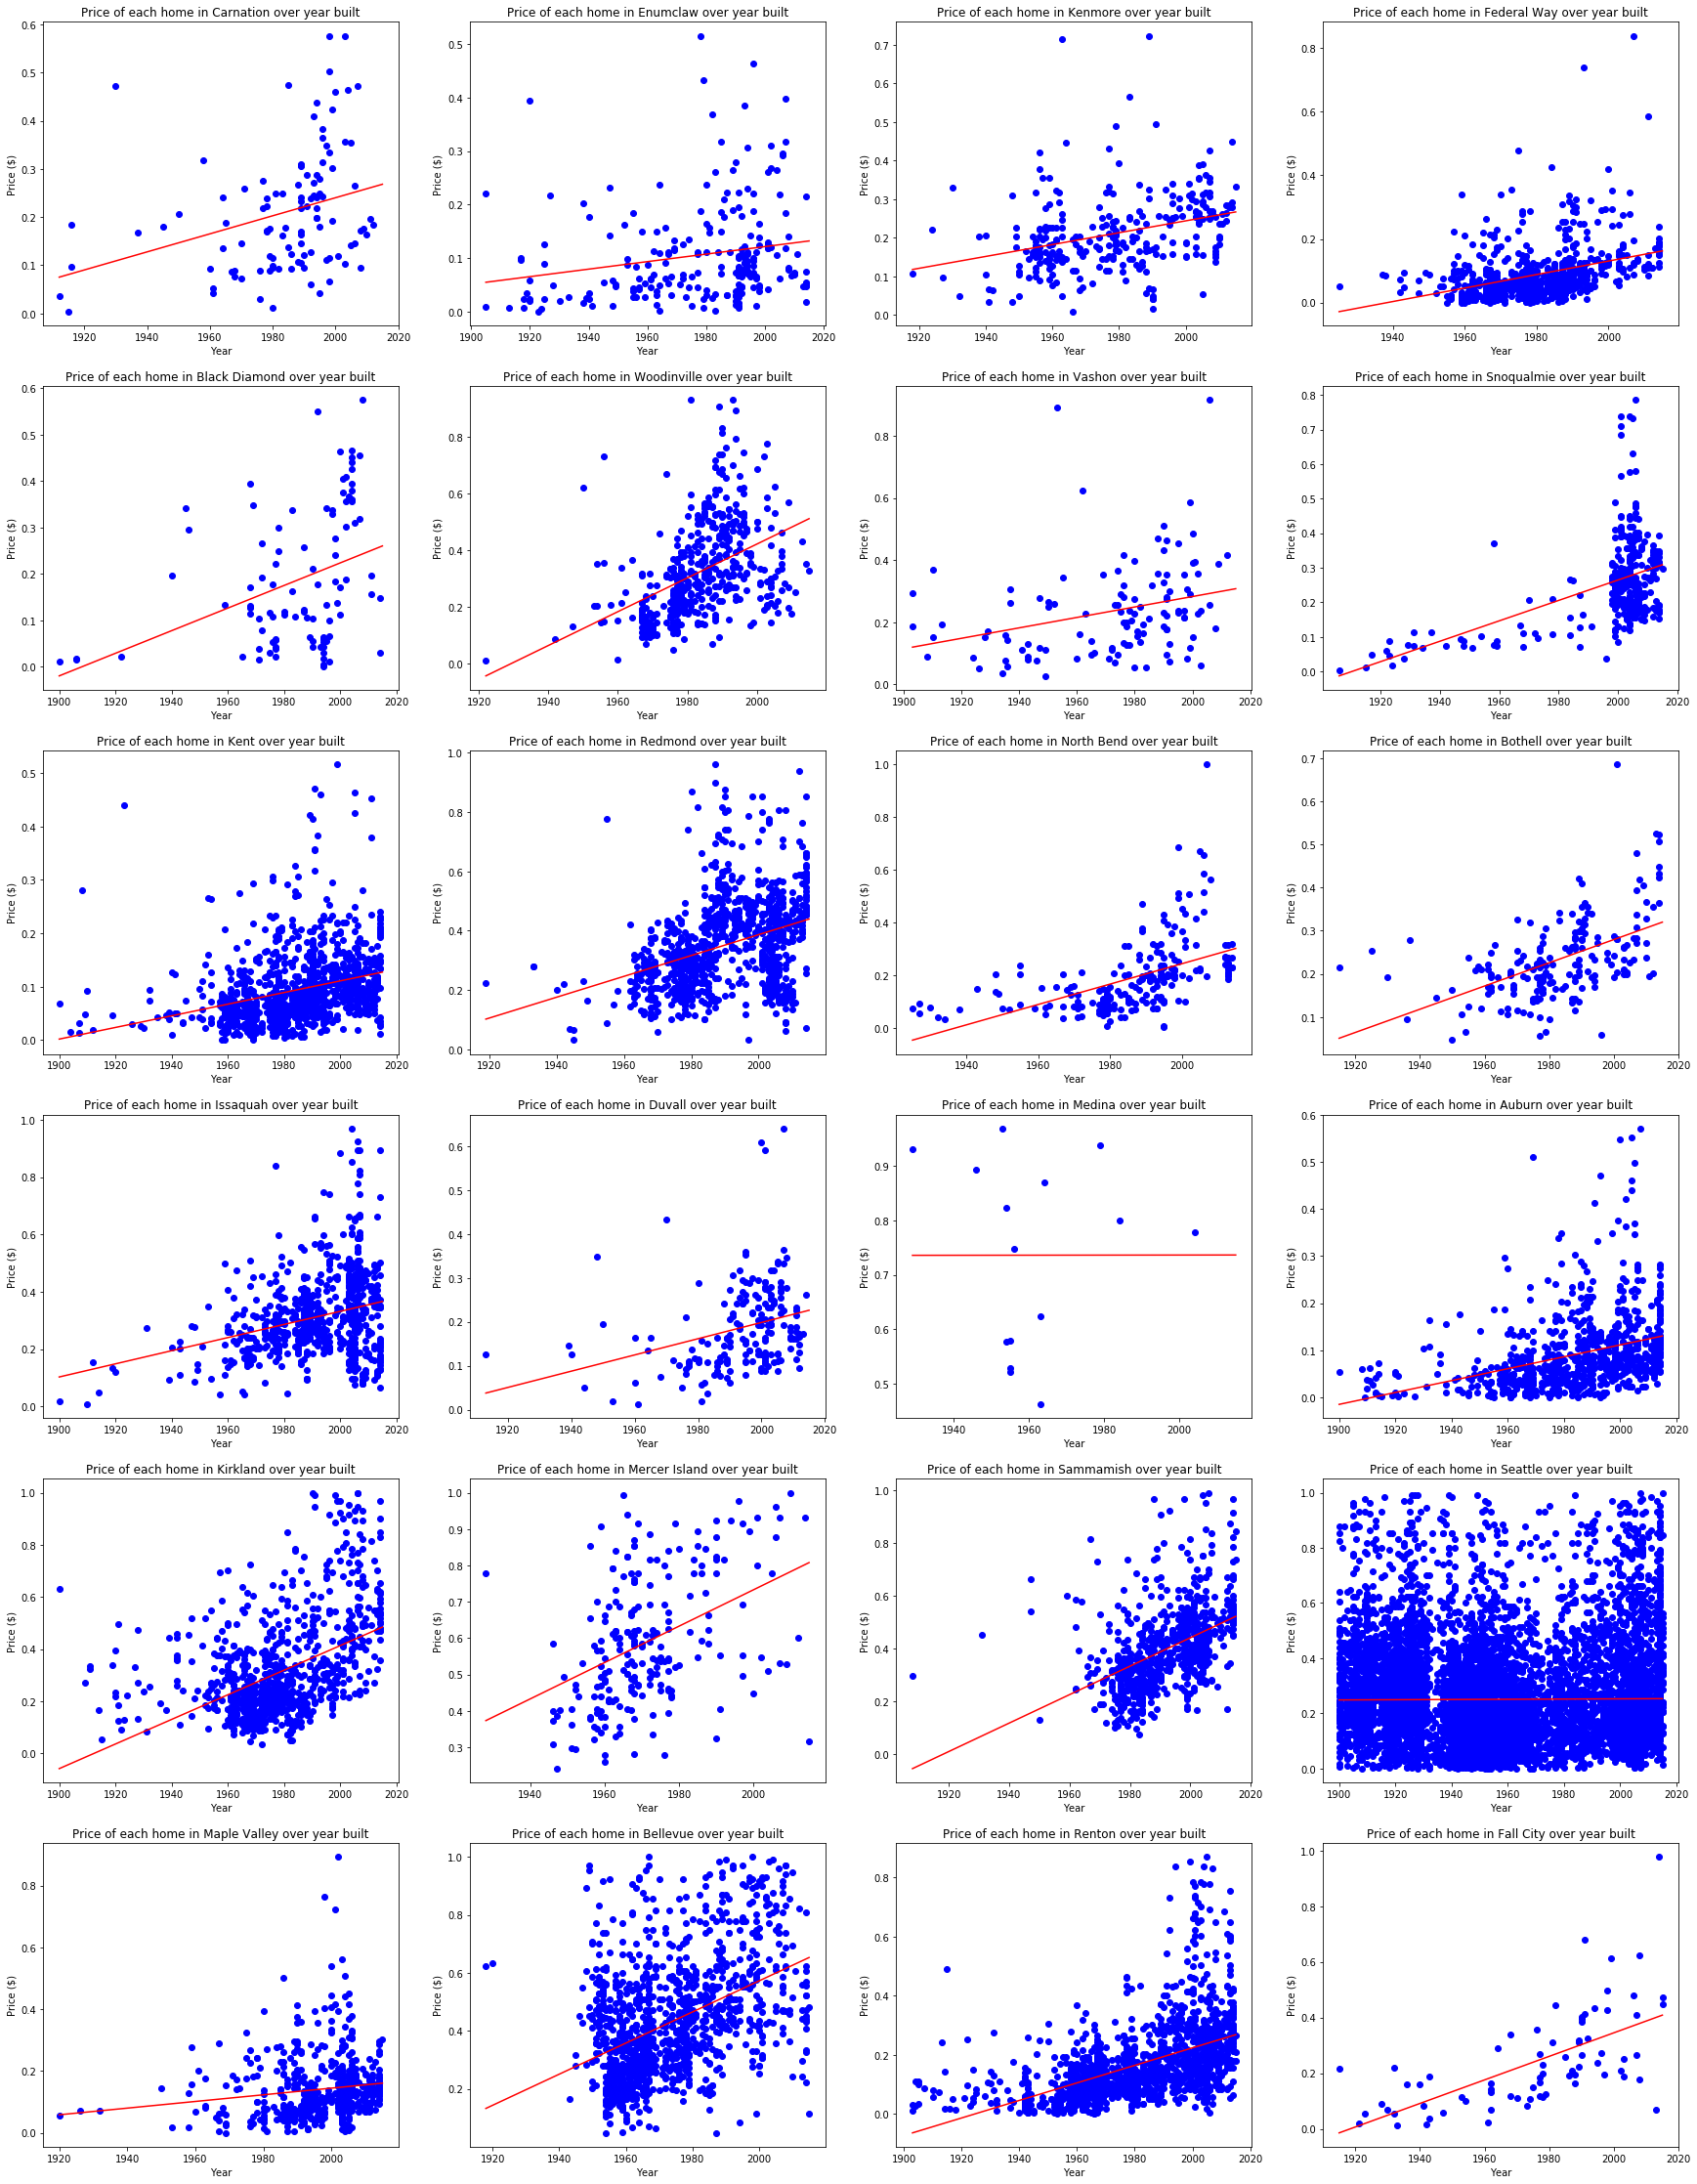

In [0]:
ROW = 6
COL = 4
counter = 0
cap = COL
fig, axes = plt.subplots(ROW, COL, figsize=(30, 40))

cities = set(normalized_df["city"])
sum_slope = 0

for city in cities:
  r, c = convert_1d_to_2d(counter, cap)
  counter += 1

  sub_df = normalized_df[normalized_df["city"] == city]
  axes[r, c].set_title("Price of each home in " + city + " over year built")
  axes[r, c].set_xlabel("Year Built")
  axes[r, c].set_ylabel("Price ($)")
  x = sub_df["non_normalized_yr"]
  y = sub_df["price"]
  axes[r, c].plot(x, y, "bo")
  model = LinearRegression()
  model.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
  xs = np.linspace(np.min(x), 2015, 5)
  ys = model.predict(xs[:, np.newaxis])
  sum_slope += model.coef_[0,0]
  axes[r, c].plot(xs,ys, "-r")

**Analysis**: The code above plots every house's price and year for each city. In addition, the data is fitted with a linear regression which is plotted in red, indicating a potential trend between Year and price. By looking at the graphs, it is clear that for the most part the slope of each trend line increases. This is verified by the calculation below that averages the slopes of all fitted lines. The average slope is 5017.988 which means that the house price across the entire country increases by $5017.988 per year. This explains a general increase in housing costs over time.

In [0]:
average_slope = sum_slope / len(cities)
average_slope # in terms of normalized value

0.0026928637907434392

In [0]:
normalized_county_df = normalized_df.sample(n=1350)

# Example 
def randome_points(amount, LON_min, LON_max, LAT_min, LAT_max):

    points = []
    for _ in range(amount):
        points.append((random.uniform(LON_min, LON_max),random.uniform(LAT_min, LAT_max)))

    return(points)

# Function to draw points in the map
def draw_points(map_object, list_of_points, layer_name, line_color, fill_color, text, prices):

    fg = folium.FeatureGroup(name=layer_name)

    for i in range(len(list_of_points)):
        curr_point = prices[i]
        point = list_of_points[i]
        slope = 510
        green = 255
        red = 0
        if curr_point < 0.5:
          green = 255
          red = curr_point*slope
        else:
          red = 255
          green = -510*curr_point + 510
        clr = '#{:02x}{:02x}{:02x}'.format( int(red), int(green) , 60)
        fg.add_child(folium.CircleMarker(point, radius=4, color=clr, fill_color=clr,
                                         fill=True ,popup=(folium.Popup(text)),fill_opacity=1))

    map_object.add_child(fg)

price_lon = np.array(list(normalized_county_df['long']))
price_lat = np.array(list(normalized_county_df['lat']))
price_lon_lat = list(zip(price_lat, price_lon))
my_map_global = folium.Map(location=[47.5,-122.3], zoom_start=10)
draw_points(my_map_global, price_lon_lat, layer_name='Test',
           line_color='royalblue', fill_color='royalblue', text='Feature Point for house', prices=list(normalized_county_df['price']))

my_map_global

Analysis: The map above displays the location of houses put on sale and their repespective cost. Using a normalized price column from the dataframe, values that are closer to 1 are more red, and values closer to 0 are more green. Analyzing the map, it is clear that there is a significant amount of cheaper houses in most areas of Seattle. Looking South of Lake Washington and Seattle, almost all houses are cheap with no hints of red and only green. This changes as we get closer to the center of the city where most of the red dots lay in this area. First, houses on Mercer Island tend to be moderately to very expensive. Similarly, houses on the Northern part of Seattle are costlier than the south. Bellevue is different from Seattle as more expensive homes are in the center, South, and East of the city. 

Overall, the biggest key point is that homes nearest to the center of the city and close to a water source tend to be more expensive. 

In [0]:
def dist(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def avg(xys):
    xs = [i[0] for i in xys]
    ys = [i[1] for i in xys]
    
    return (np.mean(xs), np.mean(ys))

def k_means(xs, ys, k=5, epoch=10):
    least_variance = float('inf')
    best_clusters = []
    best_centroids = []
    size = len(xs)
    
    for ep in range(epoch):
        centroids = [(xs[i], ys[i]) for i in np.random.choice(size, k)]
        clusters = [[] for i in range(k)]
        
        for ind in range(size):
            x = xs[ind]
            y = ys[ind]
            
            point = (x, y)
            closest = float('inf')
            closest_centroid = -1
            
            for centroid_ind in range(len(centroids)):
                distance = dist(centroids[centroid_ind][0], 
                                centroids[centroid_ind][1], 
                                point[0], point[1])
                
                if distance < closest:
                    closest = distance
                    closest_centroid = centroid_ind
                    
            clusters[closest_centroid].append(point)
            centroids[closest_centroid] = avg(clusters[closest_centroid])
        
        variance = 0
        
        for ind in range(k):
            for pt in clusters[ind]:
                variance += dist(pt[0], pt[1], 
                                 centroids[ind][0], centroids[ind][1])
        
        if variance < least_variance:
            best_clusters = clusters
            least_variance = variance
            best_centroids = centroids
            
        print(str((ep / epoch) * 100) + "%")

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown']
    circles = []
    order = {}
    
    for i in range(k):
        xs = [x[0] for x in best_clusters[i]]
        ys = [y[1] for y in best_clusters[i]]
        centroid = best_centroids[i]
        
        longest_distance = 0
        
        for j in range(len(xs)):
            x = xs[j]
            y = ys[j]
            distance = dist(x, y, centroid[0], centroid[1])
            
            if distance > longest_distance:
                longest_distance = distance
          
        order[i] = longest_distance

    
    order = sorted(order.items(), key=lambda x: x[1])
    
    for ind in range(k): 
        elm = order[ind][0]
        folium.Popup(best_centroids[elm][0], best_centroids[elm][1], ind + 1)

        folium.Circle(radius=10000,
                            color=colors[ind],
                            fill=True,
                            location=[best_centroids[elm][0], 
                                      best_centroids[elm][1]],
                            popup='Congestedness Rank: {}'.format(int(ind) + 1)
                            ).add_to(visual_map)
    

def find_most_dangerous_regions_in_washington(separated_by=3, accuracy=10):
    k_means(normalized_df['lat'].values, 
            normalized_df['long'].values, 
            min(separated_by, 7), 
            max(accuracy, 10))
    
visual_map = folium.Map(location=[47.5, -122.3], zoom_start=10)

find_most_dangerous_regions_in_washington(5, 10)

visual_map


# In pop-up, add the average price of houses in each region

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


**How Does a House's Age Affect its Price?**

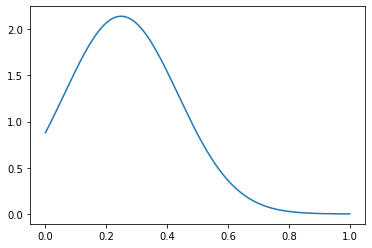

In [0]:
h = normalized_df["price"]
h = np.sort(h)
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf) # including h here is crucial

In [0]:
map_osm = folium.Map(location=[47.5, -122.3], zoom_start=10)
coords = normalized_df.sample(n=1200).as_matrix(["lat", "long"])
HeatMap(coords, radius=17.5).add_to(map_osm)
map_osm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


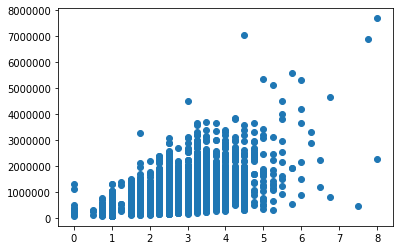

In [0]:
# load dataset

X = df[["bedrooms"]].values
X = X.astype(float)
Y = df[["price"]].values
dt = LinearRegression()
cross_val_score(dt, X, Y, cv=10)
plt.scatter(df["bathrooms"], df["price"])

In [0]:
model.predict(np.array([4]).reshape(1,1))
# sqft_above", "condition", "bedrooms", "bathrooms"

array([[-8.1000009]])